# 2D multivariate ENSO index (MEI) using ECMWF ERA-20C data

In this tutorial we will explore the ERA-20C dataset provided by ECMWF. In particular, we will reproduce the multivariate ENSO index (MEI) that was originally published by [Wolter and Timlin: Monitoring ENSO in COADS with a seasonally adjusted principal component index, (1993)](https://psl.noaa.gov/enso/mei.old/WT1.pdf) and reproduced in [Schmidt et al. Spectral Empirical Orthogonal Function Analysis of Weather and Climate Data, 2019](https://flowphysics.ucsd.edu/wp-content/papercite-data/pdf/schmidtetal_2019_mwr.pdf). 
Multivariate indices, like the MEI index are typically used to reveal interplay among different variables. The MEI index is composed of 6 variables: 
- Mean sea level pressure (MSL)
- Zonal component of the surface wind (U10)
- Meridional component of the surface wind (V10)
- Sea surface temperature (SST)
- 2-meter temperature (T2M), and 
- Total cloud cover (TCC).

We will download the monthly averages of the above variables from 1900 to 2010. 

As originally done in the original work by *Wolter and Timlin*, we normalize the data associated to each variable by its total variance. We will see how the use of PySPOD helps identifying spatio-temporal coherent structures associated to the 6 variables considered, and make some considerations on the possible interplay among them. 

## Download data

The first step to use `PySPOD` for investigating the multivariate ENSO index (MEI), is to download the relevant data. This step can require a few hours, depending on your internet connection and on how busy ECMWF server is. Also, please note that the amount of data that needs to be downloaded is approximately 443MB. 

In order to download the required data from the ECMWF, you should create an account and follow the instructions here: https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets

Once you have an account to access ECMWF data, you can simply run:
`python3 E20C_MONTHLYMEAN00_1900_2010_MEI.py`

This should download a netCDF file called `E20C_MONTHLYMEAN00_1900_2010_MEI.nc` in the current directory `tutorials/climate/ERA20C_MEI_2D/`. Please, make sure that this is the case. 

## Loading and configuring data

Once we have gained access to ECMWF datasets and downloaded the required file `E20C_MONTHLYMEAN00_1900_2010_MEI.nc`, we can proceed to use `PySPOD` to identify coherent structures in the data. The first step from this perspective is to import the required libraries, including the custom libraries 
- `from pyspod.spod.standard  import Standard  as spod_standard`
- `from pyspod.spod.streaming import Streaming as spod_streaming`

that include two different implementations of the SPOD algorithm, the first being a standard algorithm, and the second being a streaming algorithm, that requires little amount of memory (both storage and RAM) but runs typically slower than the standard algorithm.

Note that we also import the custom library 
- `import library.weights as weights`

that implements the weight matrix for data defined on a sphere (e.g. the atmospheric data we are using). 

In [1]:
import os
import sys
import time
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Current path
CWD = os.getcwd()

# Import library specific modules
sys.path.insert(0, "../../../")
from pyspod.spod.standard  import Standard  as spod_standard
from pyspod.spod.streaming import Streaming as spod_streaming
import pyspod.utils.weights  as utils_weights

We then need to load the data from the netCDF file and inspect:

In [2]:
# Inspect and load data 
file = os.path.join(CWD,'ERA5_monthly_1940_2024.nc')
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset> Size: 711MB
Dimensions:     (valid_time: 1020, latitude: 121, longitude: 240)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 968B 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude   (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    expver      (valid_time) <U4 16kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 118MB ...
    msl         (valid_time, latitude, longitude) float32 118MB ...
    tcc         (valid_time, latitude, longitude) float32 118MB ...
    u10         (valid_time, latitude, longitude) float32 118MB ...
    v10         (valid_time, latitude, longitude) float32 118MB ...
    t2m         (valid_time, latitude, longitude) float32 118MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Convent

the netCDF file contains **3 coordinates**:
- longitude,
- latitude,  
- time, 

along with **6 variables**:

- sst (sea surface temperature),
- msl (mean seal level pressure),
- tcc (total cloud cover),
- u10 (horizontal velocity; u-component),
- v10 (horizontal velocity; v-component),
- t2m (2-meters temperature).

We first load `time`, and the two spatial coordinates `longitude` and `latitude`, and we store them into three different arrays, `t`, `x1` and `x2`, respectively. Let's look at their dimensions to see the number of time snapshots, and the length of longitude and latitude.

In [3]:
# we extract time, longitude and latitude
t = np.array(ds['valid_time'])
x1 = np.array(ds['longitude'])
x2 = np.array(ds['latitude'])
nt = t.shape[0]
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)

shape of t (time):  (1020,)
shape of x1 (longitude):  (240,)
shape of x2 (latitude) :  (121,)


We then need to load the data in a format that is suitable to the `PySPOD` library, that is
- first dimension must correspond to the number of time snapshots (1332 in our case)
- last dimension should corresponds to the number of variables (6 in our case)
- the remaining dimensions corresponds to the spatial dimensions (240, and 121 in our case, that correspond to longitude and latitude).

Let's load and reshuffle it, in order to meet this requirement, and check its dimensions. 

In [4]:
# we set the variables we want to use for the analysis
# (we select all the variables present) and load them in RAM
variables = ['sst', 'msl', 'tcc', 'u10', 'v10', 't2m']
X = np.empty([t.shape[0], x1.shape[0], x2.shape[0], len(variables)])
for i,var in enumerate(variables):
    X[...,i] = np.einsum('ijk->ikj', np.array(ds[var]))
    X[...,i] = np.nan_to_num(X[...,i])
print('shape of data matrix X: ', X.shape)

shape of data matrix X:  (1020, 240, 121, 6)


We can see that: 
- the **first dimension is 1020**, and corresponds to the **number of time snapshots**; 
- the **second is 240**, and corresponds to the **number of longitude points**;
- the **third is 121**, and corresponds to the **number of latitude points**;
- the **fourth is 6**, and corresponds to the **number of variables**.

Indeed, we use as first dimension the number of time snapshots, as last dimension the number of variables and as middle dimensions, the spatial dimensions, that in our case are two and correspond to longitude and latitude.

<font color='green'> **NOTE I : we used `np.nan_to_num` to set possible NaN (not-a-number) to zero. The amount of NaN in this case is relatively small, and setting them to zero is a feasible approximation. For your specific application you might want to apply a different replacement for NaN (if present).**</font>

<font color='green'> **NOTE II: we also used `np.einsum` in order to match the axes dimensions to the dimensions of the data, i.e. to obtain a matrix shape $1332 \times 240 \times 121$.**</font>

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `time_step`: time-sampling of the data (for now this must be constant)
- `n_snapshots`: number of time snapshots
- `n_space_dims`: number of spatial dimensions
- `n_variables`: number of variables
- `n_dft`: length of FFT blocks

The optional parameters are as follows:
- `overlap`: dimension of the overlap region between adjacent blocks in percentage (0 to 100)
- `mean_type`: type of mean to be subtracted from the data (`longtime`, `blockwise` or `zero`)
- `normalize_weights`: weights normalization by data variance
- `normalize_data`: normalize data by variance
- `n_modes_save`: number of modes to be saved
- `conf_level`: calculate confidence level of modes
- `reuse_blocks`: whether to attempt reusing FFT blocks previously computed (if found)
- `savefft`: save FFT blocks to reuse them in the future (to save time)
- `savedir`: where to save the data


<font color='green'> **Note: we used the built-in module `utils_weights`, and in particular the function `utils_weights.geo_trapz_2d` to construct the weights for our problem on the sphere. This function builds weights according to lon-lat grids on the sphere and can be generally used for  two-dimensional atmospheric data. You can implement your own weights into the `custom` function inside `utils_weights.py` or by readily providing the weights as a numpy.ndarray. The weights must have a shape equal to the data spatial dimensions $\times$ number of variables, that is:**
    
$\textsf{weights dim} = \textsf{number of spatial dimensions} \times \textsf{number of variables}$. </font>

In [5]:
# define required and optional parameters
params = dict()

# -- required parameters
params['time_step'   ] = 720              # data time-sampling
params['n_snapshots' ] = len(t)           # number of time snapshots (we consider all data)
params['n_space_dims'] = 2                # number of spatial dimensions (longitude and latitude)
params['n_variables' ] = len(variables)   # number of variables
params['n_dft'       ] = np.ceil(12 * 5)  # length of FFT blocks (100 time-snapshots)

# -- optional parameters
params['overlap'          ] = 0             # dimension block overlap region
params['mean_type'        ] = 'blockwise'   # type of mean to subtract to the data
params['normalize_weights'] = True          # normalization of weights by data variance
params['normalize_data'   ] = False         # normalize data by data variance
params['n_modes_save'     ] = 3             # modes to be saved
params['conf_level'       ] = 0.95          # calculate confidence level
params['reuse_blocks'     ] = False         # whether to reuse blocks if present
params['savefft'          ] = False         # save FFT blocks to reuse them in the future (saves time)
params['savedir'          ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results

# Set weights
weights = utils_weights.geo_trapz_2D(
	x1_dim=x2.shape[0], x2_dim=x1.shape[0],
	n_vars=len(variables), R=1)

Note that for this tutorial we normalize the weights by data variance by setting `params['normalize_weights'] = True`. This step is performed as in (Wolter and Timlin, 1993) and (Schmidt et al., 2019). 

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `spod_standard(params=params, weights=weights)` and the `fit` method, `SPOD_analysis.fit(data_list=X)`. 

The `PySPOD` constructor takes the parameters `params`, and `weights`.

The method `fit` takes as inputs `data_list`, that can either be a `numpy.ndarray` containing the data or a list of `xarray.DataArray`s.
  
The `fit` method returns a `PySPOD` object containg the results.

In [6]:
# Perform SPOD analysis using the standard module
SPOD_analysis = spod_standard(
	params=params,
	weights=weights)

# Fit SPOD
spod = SPOD_analysis.fit(data_list=X)

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
nx: 29040
dim: 4
shape: (1, 240, 121, 6)
xdim: 2
xshape: (240, 121)
nt: 1020
- checking weight dimensions
- distributing data (if parallel)
--- reading data (1 stage reader) finished in 0.29 s
- loaded data into memory: 1.1920928955078125e-06 s.
- computed mean: 0.11508870124816895 s.
- normalizing weights

Normalization by variance - serial
----------------------------------
SPOD parameters
------------------------------------
Problem size (real)      : 1.32 GB (min 1.32 GB/proc, max 1.32 GB/proc)
Problem size (complex)   : 2.65 GB (min 2.65 GB/proc, max 2.65 GB/proc)
Data type for real       : <class 'numpy.float64'>
Data type for complex    : <class 'numpy.complex128'>
No. snapshots per block  : 60
Block overlap            : 0
No. of blocks            : 17
Windowing fct. (time)    : hamming
Weighting fct. (space)   : geo_trapz_2D
Me

## Postprocessing and visualizing results

The results are stored in a `PySPOD` object that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postproc` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [7]:
# Show results
T_approx = 876 # approximate period (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_req=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postproc` module. We note that the eigenvalues are all real.

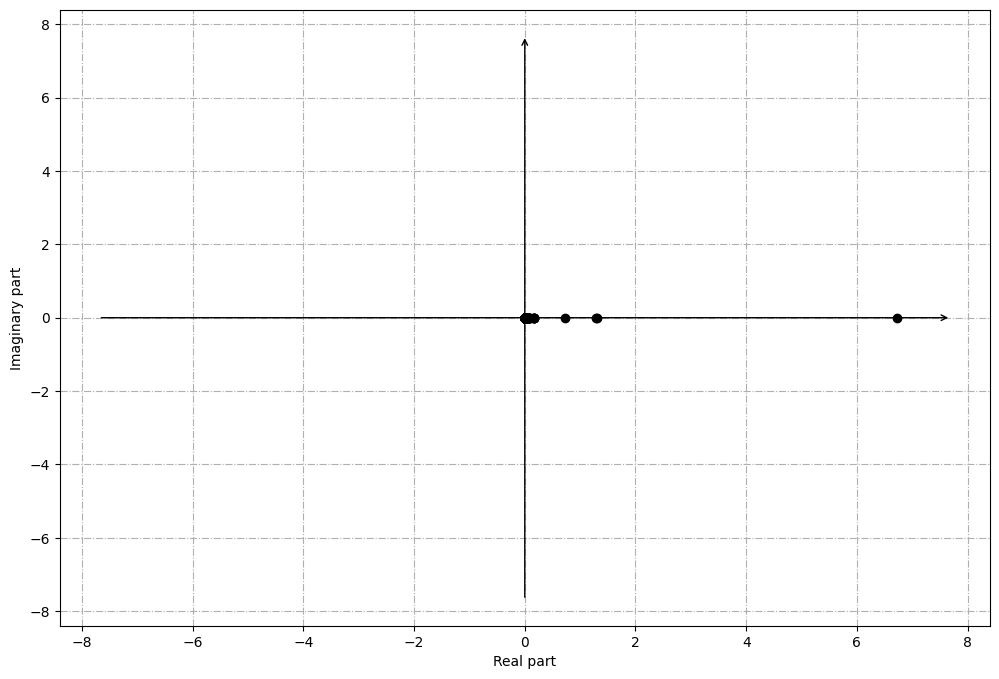

In [8]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 24, that is the number of hours in a day, to obtain a period for the x-axis in days). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

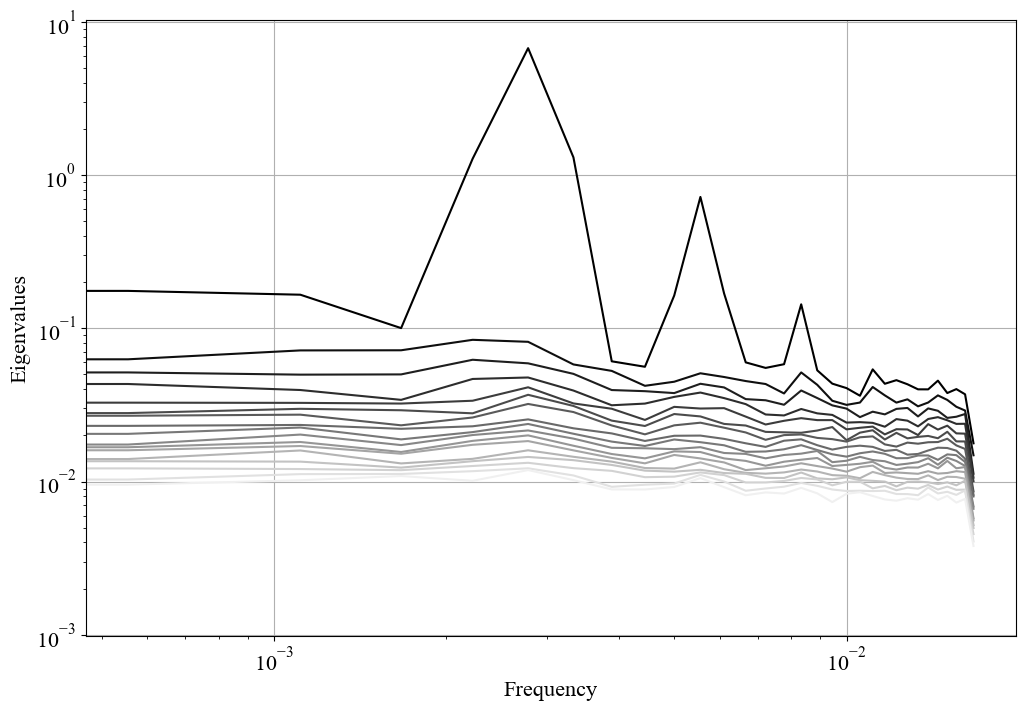

In [9]:
freq = spod.freq*24
spod.plot_eigs_vs_frequency(freq=freq)

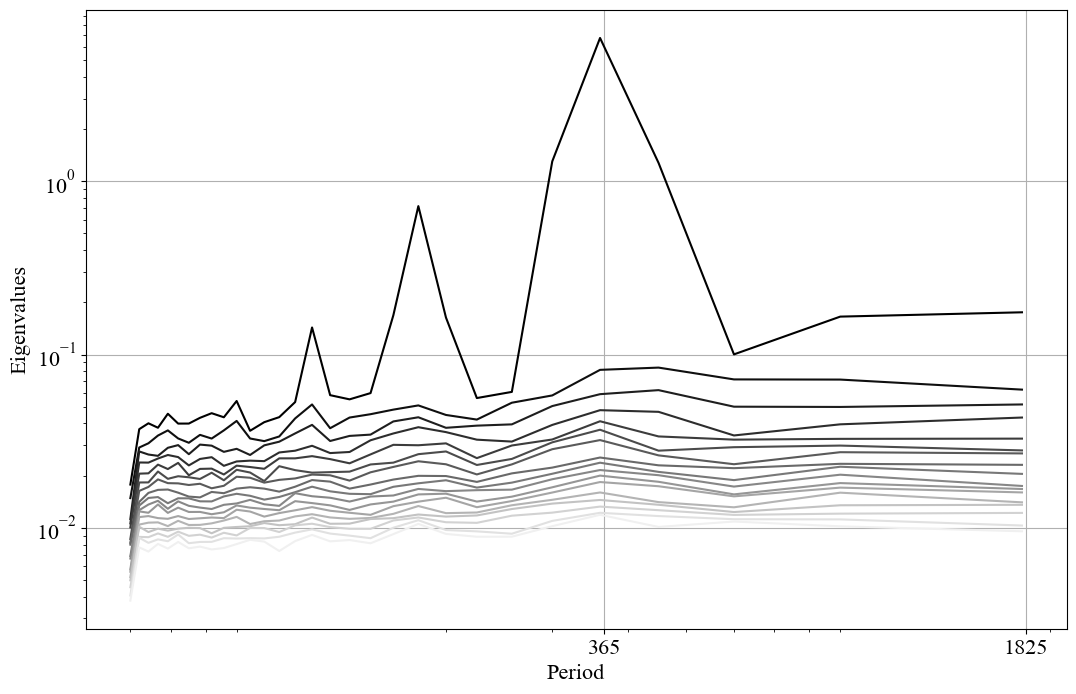

In [10]:
spod.plot_eigs_vs_period(freq=freq, xticks=[365, 1825])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2d_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 876 days that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to longitude and latitude. We finally pass a parameter `coastlines='centred'`, that overlays a world map on top of our data. Note that we **shift longitude of 180**, as we use coastlines that goes from -180, to 180, while our data was provided from 0 to 360. 

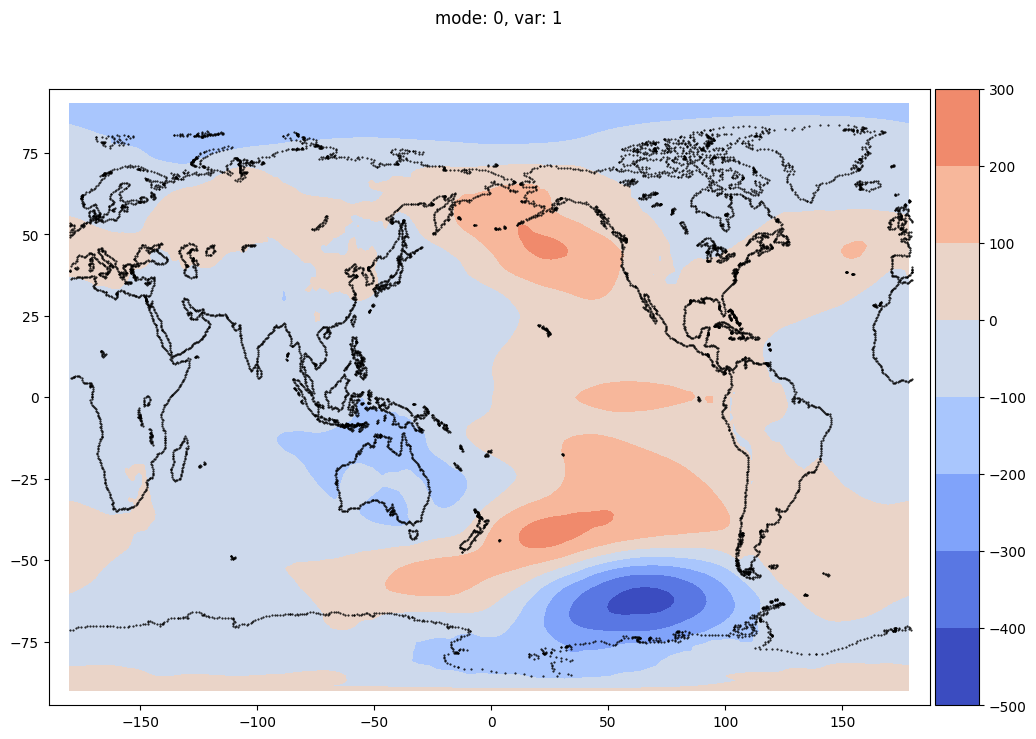

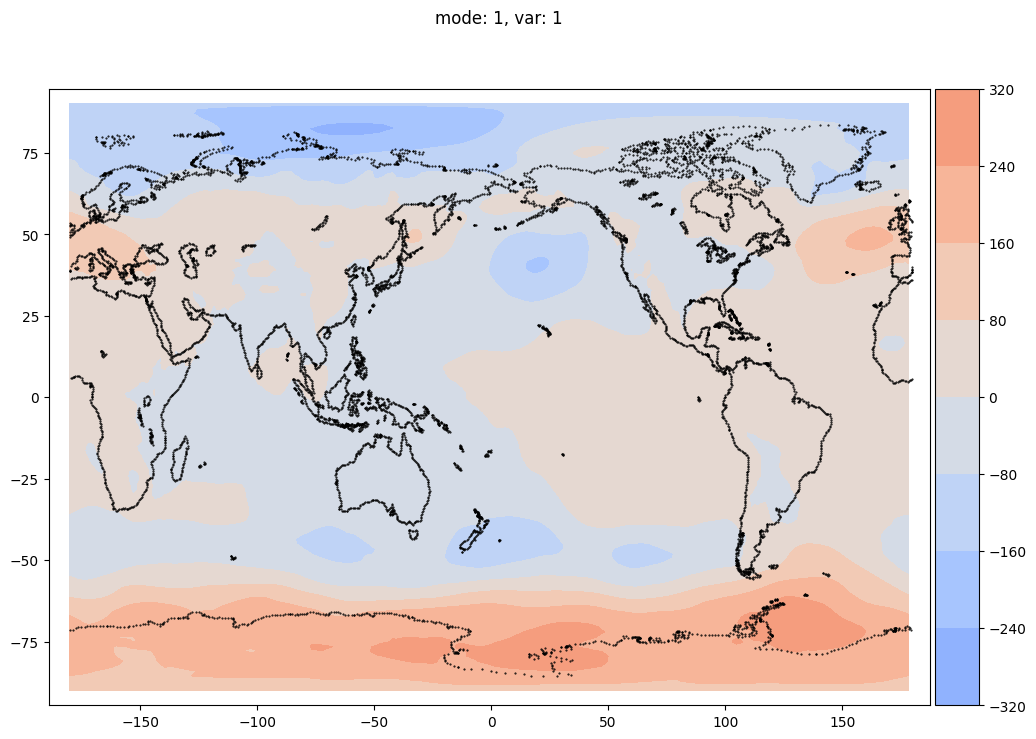

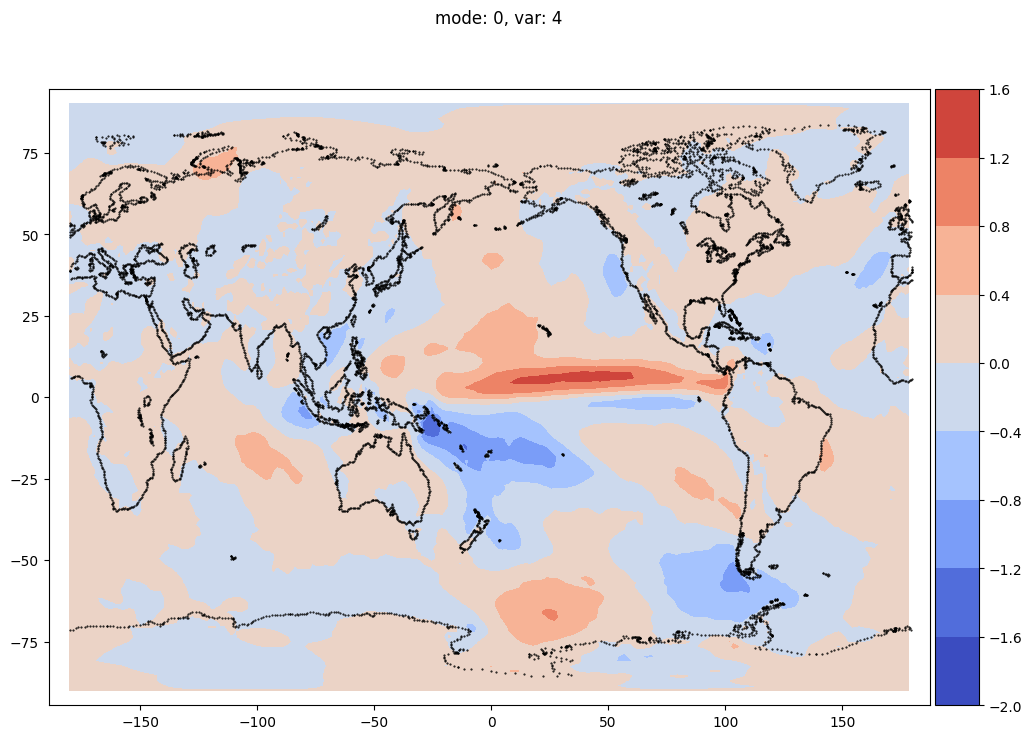

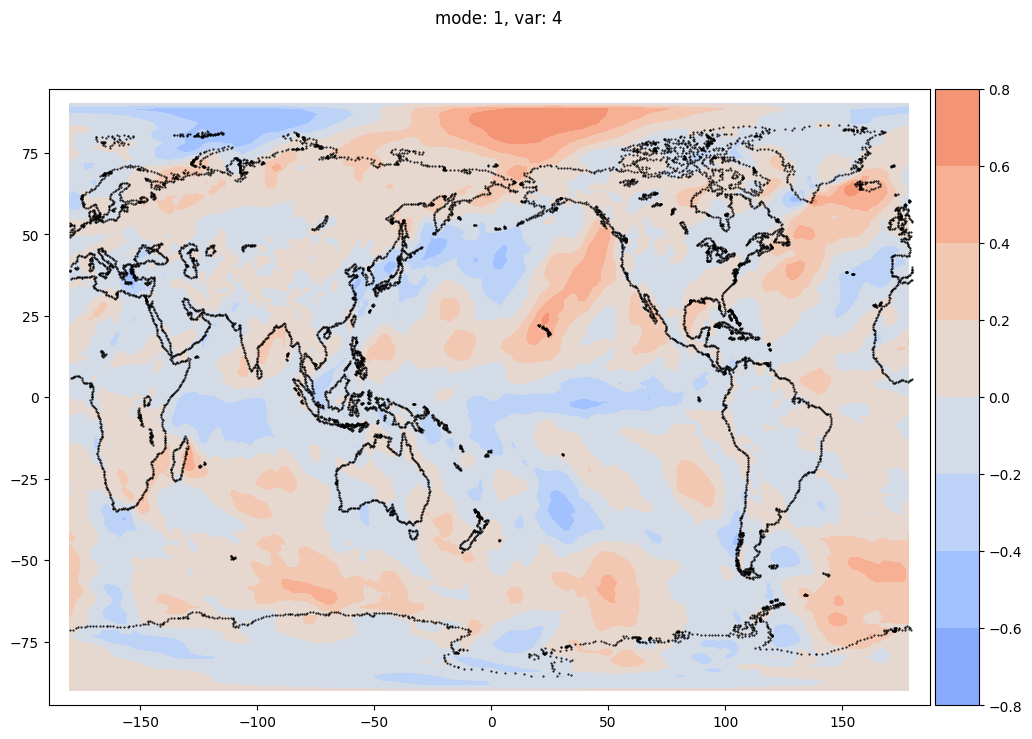

In [11]:
spod.plot_2d_modes_at_frequency(
    freq_req=freq_found, 
    freq=freq, 
    x1=x1-180, 
    x2=x2, 
    coastlines='centred', 
    modes_idx=[0,1], 
    vars_idx=[1,4])

Note that we can also plot the **original data** by

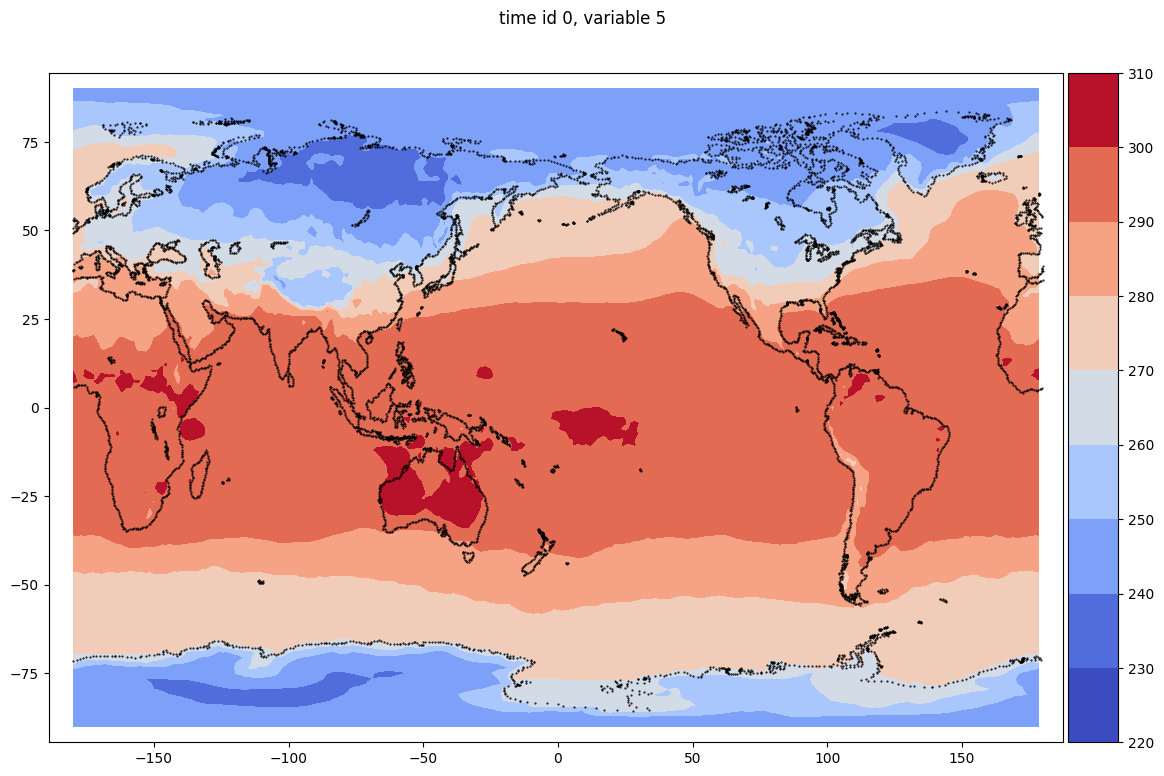

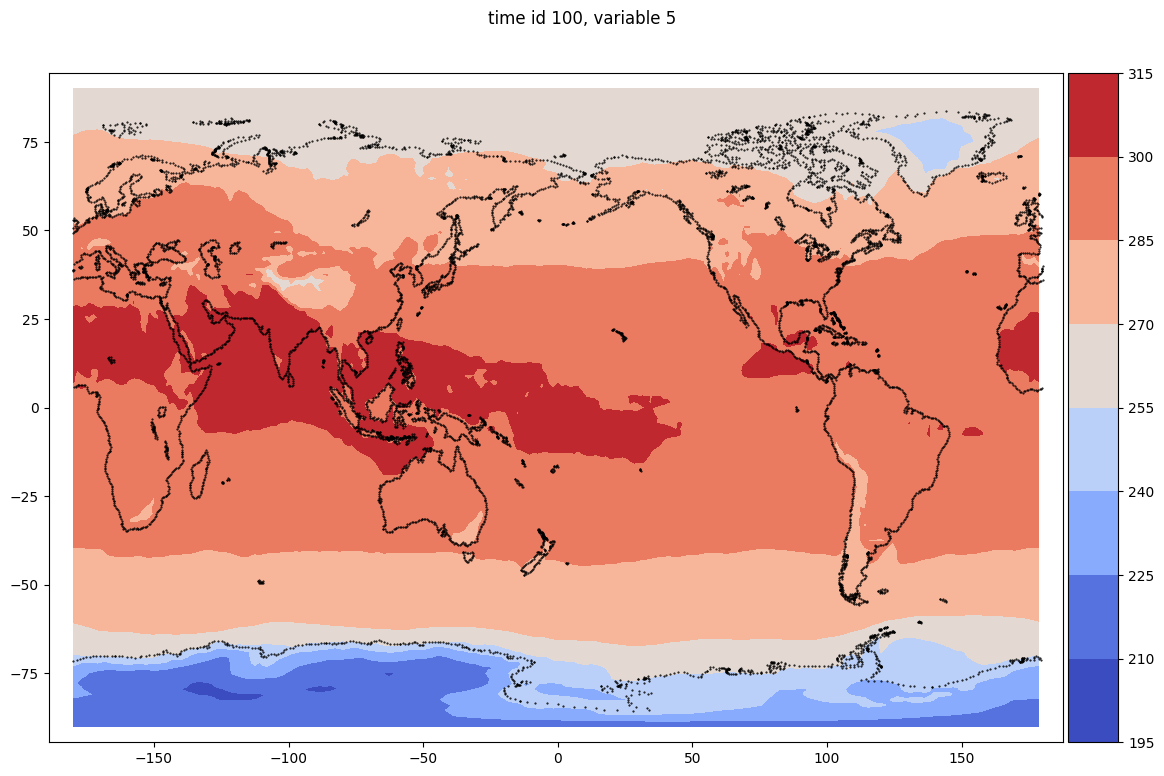

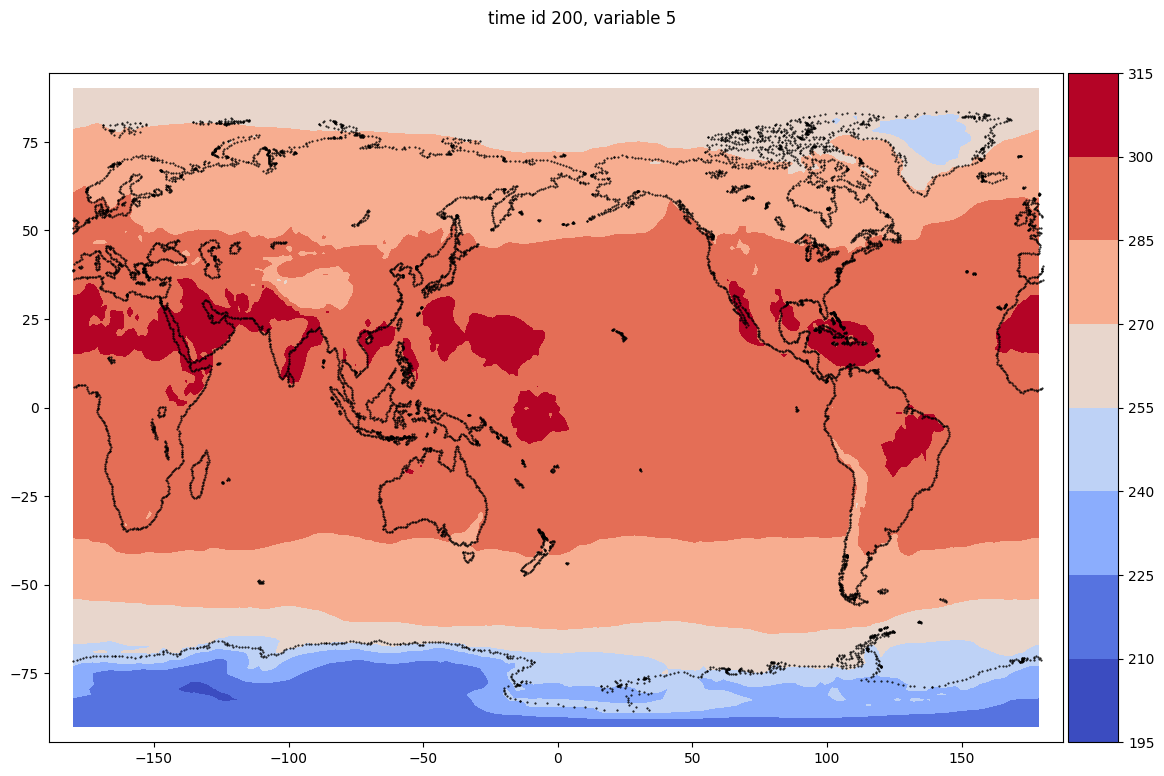

In [12]:
data = spod.get_data(X)

spod.plot_2d_data(
    data,
    x1=x1-180, 
    x2=x2, 
    coastlines='centred', 
    vars_idx=[5], 
    time_idx=[0,100,200])

Along with a video of the original data

In [27]:
spod.generate_2d_data_video(
    data,
    time_limits=[0,50],
    x1=x1-180, 
    x2=x2, 
    coastlines='centred', 
    sampling=1,
    vars_idx=[5],
    filename='data_video.mp4'
    )

In [28]:
#play the video
from IPython.display import Video, display
results_dir = spod.savedir_sim
video_path = results_dir + '/data_video_var5.mp4'

if os.path.exists(video_path):
    display(Video(video_path, embed=True, width=800, height=400))
else:
    print(f"Video file not found: {video_path}")
    
## -------------------------------------------------------------

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params['savedir']`. You can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exist several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to your specific post-processing pipeline.

This tutorial was intended to help you setup your own multivariate case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. 